# Supervised automatic discretisation of continuous variables

In [1]:
import warnings
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import kruskal

warnings.simplefilter(action='ignore', category=FutureWarning)

def decoup(base, x, y, h=0, k=0, pAUC=0, nbmod=3, calcul=1, algo='Nelder-Mead', graphe=0):
    Xt = base[x].dropna()
    Yt = base[y].dropna()

    X = Xt
    Y = Yt

    seuils = np.quantile(X, np.linspace(0, 1, nbmod+1))[1:nbmod]

    def fitauc(s):
        s2 = np.concatenate(([-np.inf], np.unique(s), [np.inf]))
        qX = pd.cut(X, bins=s2)
        logit = LogisticRegression(solver='liblinear').fit(pd.get_dummies(qX, drop_first=True), Y)
        qXn = logit.predict_proba(pd.get_dummies(pd.cut(base[x], bins=s2), drop_first=True))[:, 1]
        auc_value = roc_auc_score(Y, qXn)
        prop_table = pd.crosstab(qX, Y, normalize='index')
        result = (auc_value * (1 - np.sum((pd.value_counts(qX, normalize=True) ** 2))) / 
                 (1 - (1-h) * (np.sum((pd.value_counts(qX, normalize=True) ** 2)))) * 
                 ((1 - (1-k) * (np.sum(prop_table.iloc[:, 1] ** 2))) / 
                 (1 - np.sum(prop_table.iloc[:, 1] ** 2))))
        return -result

    def applical():
        sf = np.concatenate(([-np.inf], est.x, [np.inf]))
        qX = pd.cut(Xt, bins=sf)
        tab = pd.crosstab(pd.cut(Xt, bins=sf), Yt)
        print("\nResult of cutting :\n")
        print("\nTresholds      % Negative  % Positive   # +   #   % #")
        print(pd.concat([tab.div(tab.sum(axis=1), axis=0) * 100, tab.iloc[:, 1], tab.sum(axis=1), tab.sum(axis=1) * 100 / len(Xt)], axis=1))
        print("\nConvergence indicator (0 = convergence optimisation)")
        print(est.success) 
        print("\nMaximum (partial) AUC  :")
        print(-est.fun)
        print("\nClass homogeneity (0 <- low ... high -> 1) :")
        prop_table = pd.crosstab(qX, Yt, normalize='index')
        print(1 - np.sum(prop_table.iloc[:, 1] ** 2))
        return qX

    def gini(t):
        print("\nAUC before cutting :")
        logit = LogisticRegression(solver='liblinear').fit(X.values.reshape(-1, 1), Y)
        g1 = roc_auc_score(Y, logit.predict_proba(X.values.reshape(-1, 1))[:, 1])
        print(g1)
        print("\nAUC after cutting :")
        logit = LogisticRegression(solver='liblinear').fit(pd.get_dummies(t, drop_first=True), Yt)
        g2 = roc_auc_score(Yt, logit.predict_proba(pd.get_dummies(t, drop_first=True))[:, 1])
        print(g2)
        print("\n% Evolution AUC before/after cutting :")
        print(100 * (g2 - g1) / g1)
        print("\n")

    if calcul == 1:
        est = minimize(fitauc, seuils, method=algo)
    else:
        est = {'x': bornes, 'success': True, 'fun': 0}

    print("\n---------------------------------------------------------------------------")
    print(f"\nDiscretization of {x} into {nbmod} classes (algorithm {algo})")
    print("\n---------------------------------------------------------------------------")

    qX1 = applical()
    gini(qX1)

    if graphe == 1:
        base0 = X[Y == 0]
        base1 = X[Y == 1]
        
        plt.figure(figsize=(10, 6))
        
        plt.subplot(2, 1, 1)
        plt.hist(base0, bins=30, density=True, alpha=0.5, color="blue", label=f"{y} = 0")
        plt.hist(base1, bins=30, density=True, alpha=0.5, color="red", label=f"{y} = 1")
        plt.axvline(np.median(base0), color="blue", linestyle="--")
        plt.axvline(np.median(base1), color="red", linestyle="--")
        plt.legend()
        
        plt.subplot(2, 1, 2)
        plt.boxplot([base0, base1], vert=False)
        plt.yticks([1, 2], [f"{y} = 0", f"{y} = 1"])
        
        plt.tight_layout()
        plt.show()



---------------------------------------------------------------------------

Discretization of age into 2 classes (algorithm Nelder-Mead)

---------------------------------------------------------------------------

Result of cutting :


Tresholds      % Negative  % Positive   # +   #   % #
                       0          1    1    0     1
age                                                
(-inf, 34.65]  64.963504  35.036496  192  548  54.8
(34.65, inf]   76.106195  23.893805  108  452  45.2

Convergence indicator (0 = convergence optimisation)
True

Maximum (partial) AUC  :
0.5657142857142857

Class homogeneity (0 <- low ... high -> 1) :
0.8201529991311365

AUC before cutting :
0.5706333333333333

AUC after cutting :
0.5657142857142857

% Evolution AUC before/after cutting :
-0.8620329959193178




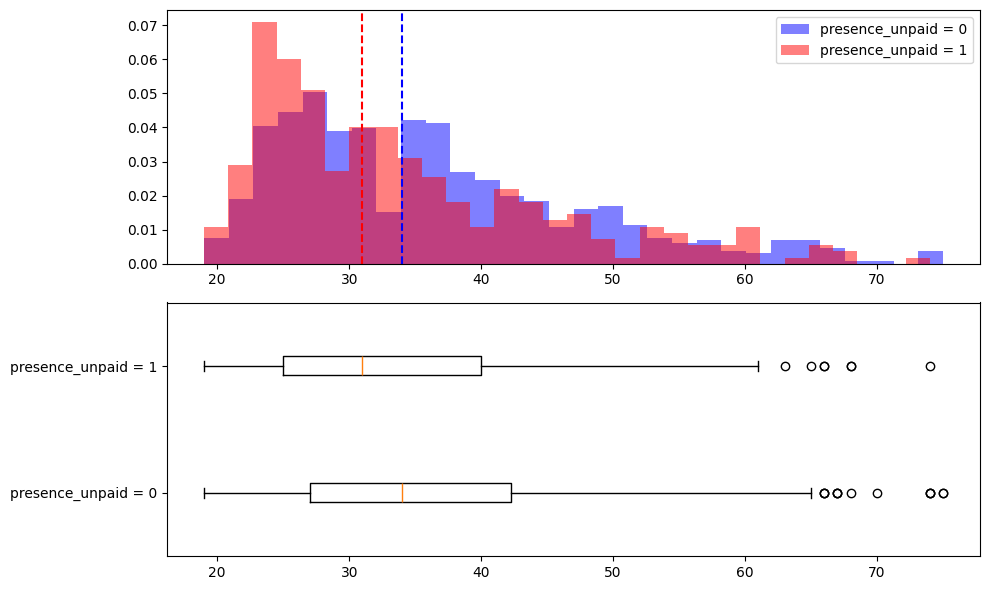


---------------------------------------------------------------------------

Discretization of age into 3 classes (algorithm Nelder-Mead)

---------------------------------------------------------------------------

Result of cutting :


Tresholds      % Negative  % Positive   # +   #   % #
                          0          1    1    0     1
age                                                   
(-inf, 29.662]    63.072776  36.927224  137  371  37.1
(29.662, 37.584]  73.684211  26.315789   75  285  28.5
(37.584, inf]     74.418605  25.581395   88  344  34.4

Convergence indicator (0 = convergence optimisation)
True

Maximum (partial) AUC  :
0.5629047619047619

Class homogeneity (0 <- low ... high -> 1) :
0.7289451584740179

AUC before cutting :
0.5706333333333333

AUC after cutting :
0.5629047619047619

% Evolution AUC before/after cutting :
-1.3543848522527164




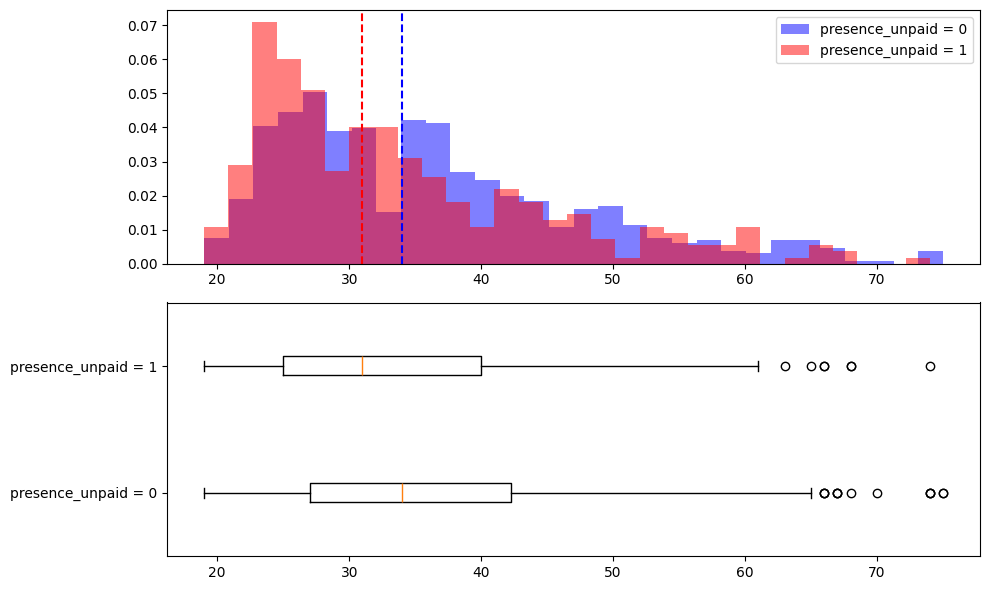


---------------------------------------------------------------------------

Discretization of age into 4 classes (algorithm Nelder-Mead)

---------------------------------------------------------------------------

Result of cutting :


Tresholds      % Negative  % Positive   # +   #   % #
                          0          1    1    0     1
age                                                   
(-inf, 25.591]    57.894737  42.105263   80  190  19.0
(25.591, 34.741]  68.715084  31.284916  112  358  35.8
(34.741, 41.277]  79.487179  20.512821   40  195  19.5
(41.277, inf]     73.540856  26.459144   68  257  25.7

Convergence indicator (0 = convergence optimisation)
True

Maximum (partial) AUC  :
0.5903333333333334

Class homogeneity (0 <- low ... high -> 1) :
0.6127538727736835

AUC before cutting :
0.5706333333333333

AUC after cutting :
0.5903333333333334

% Evolution AUC before/after cutting :
3.4523044570360506




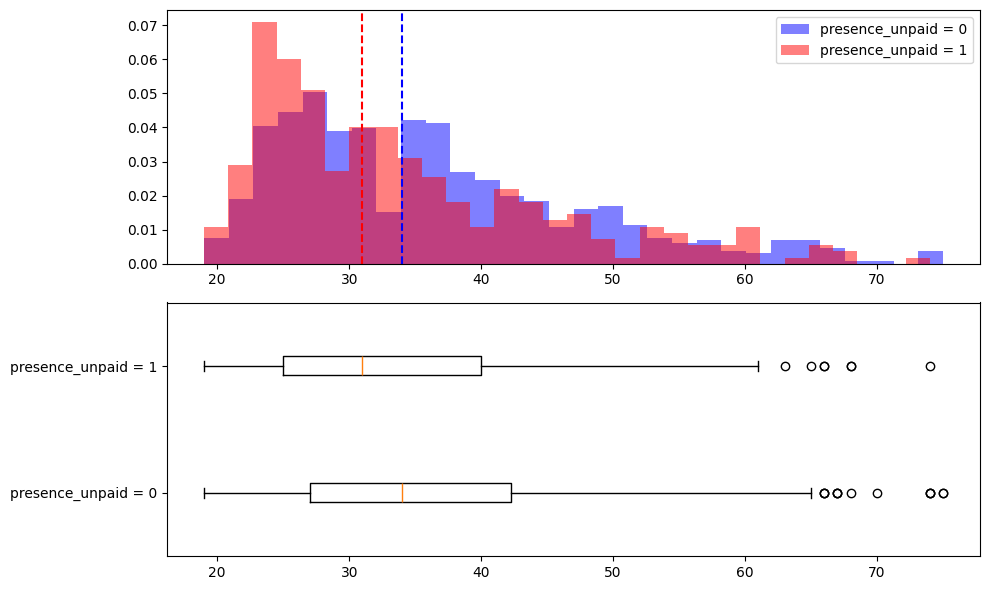


---------------------------------------------------------------------------

Discretization of age into 5 classes (algorithm Nelder-Mead)

---------------------------------------------------------------------------

Result of cutting :


Tresholds      % Negative  % Positive   # +   #   % #
                          0          1   1    0     1
age                                                  
(-inf, 25.783]    57.894737  42.105263  80  190  19.0
(25.783, 32.086]  69.965870  30.034130  88  293  29.3
(32.086, 34.153]  63.076923  36.923077  24   65   6.5
(34.153, 46.438]  77.112676  22.887324  65  284  28.4
(46.438, inf]     74.404762  25.595238  43  168  16.8

Convergence indicator (0 = convergence optimisation)
True

Maximum (partial) AUC  :
0.5894380952380952

Class homogeneity (0 <- low ... high -> 1) :
0.4782838448077028

AUC before cutting :
0.5706333333333333

AUC after cutting :
0.5894380952380952

% Evolution AUC before/after cutting :
3.2954194587467516




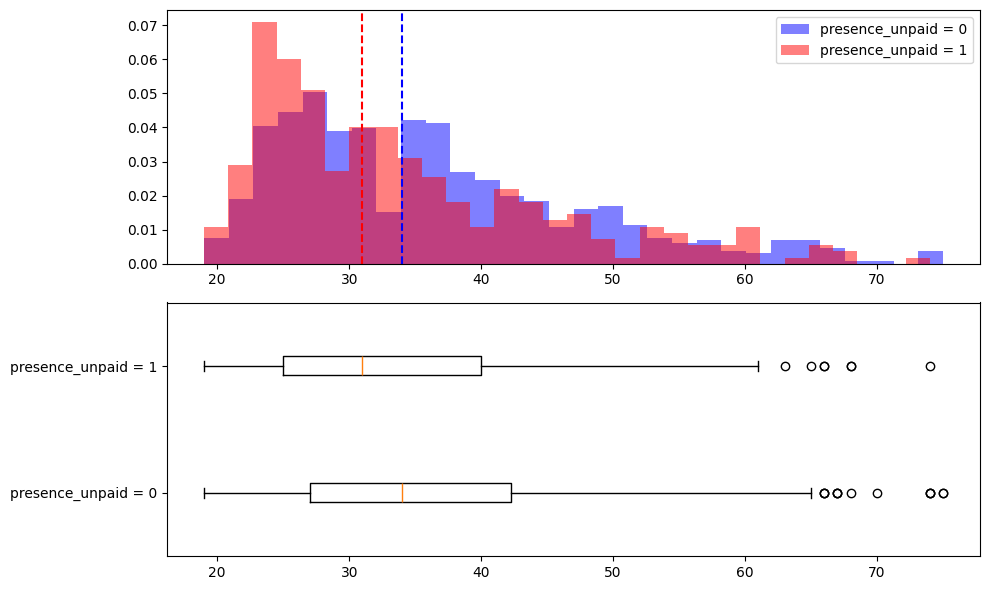

In [2]:
credit = pd.read_csv('credit.csv') 

for i in range(2, 6): 
    qX_result = decoup(credit, 'age', 'presence_unpaid', nbmod=i, h=0, k=0, pAUC=0.8, graphe=1)


---------------------------------------------------------------------------

Discretization of duration_credit into 2 classes (algorithm Nelder-Mead)

---------------------------------------------------------------------------

Result of cutting :


Tresholds      % Negative  % Positive   # +   #   % #
                         0          1    1    0     1
duration_credit                                      
(-inf, 17.1]     79.214781  20.785219   90  433  43.3
(17.1, inf]      62.962963  37.037037  210  567  56.7

Convergence indicator (0 = convergence optimisation)
True

Maximum (partial) AUC  :
0.595

Class homogeneity (0 <- low ... high -> 1) :
0.8196232542030212

AUC before cutting :
0.6285928571428572

AUC after cutting :
0.595

% Evolution AUC before/after cutting :
-5.3441359953638035




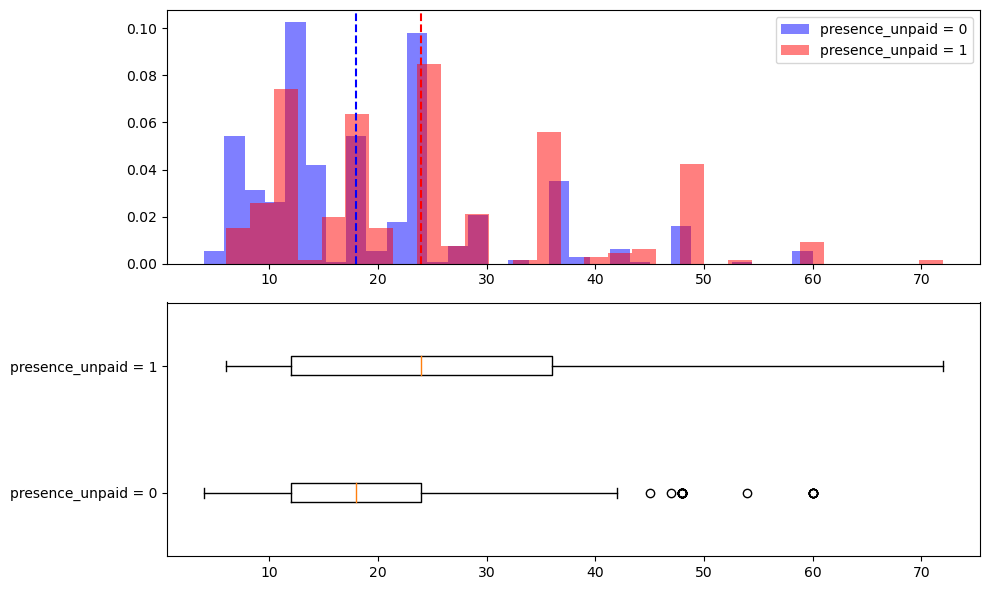


---------------------------------------------------------------------------

Discretization of duration_credit into 3 classes (algorithm Nelder-Mead)

---------------------------------------------------------------------------

Result of cutting :


Tresholds      % Negative  % Positive   # +   #   % #
                         0          1    1    0     1
duration_credit                                      
(-inf, 12.0]     78.830084  21.169916   76  359  35.9
(12.0, 24.0]     70.316302  29.683698  122  411  41.1
(24.0, inf]      55.652174  44.347826  102  230  23.0

Convergence indicator (0 = convergence optimisation)
True

Maximum (partial) AUC  :
0.6084809523809525

Class homogeneity (0 <- low ... high -> 1) :
0.6703983014937993

AUC before cutting :
0.6285928571428572

AUC after cutting :
0.6084809523809525

% Evolution AUC before/after cutting :
-3.199512137843779




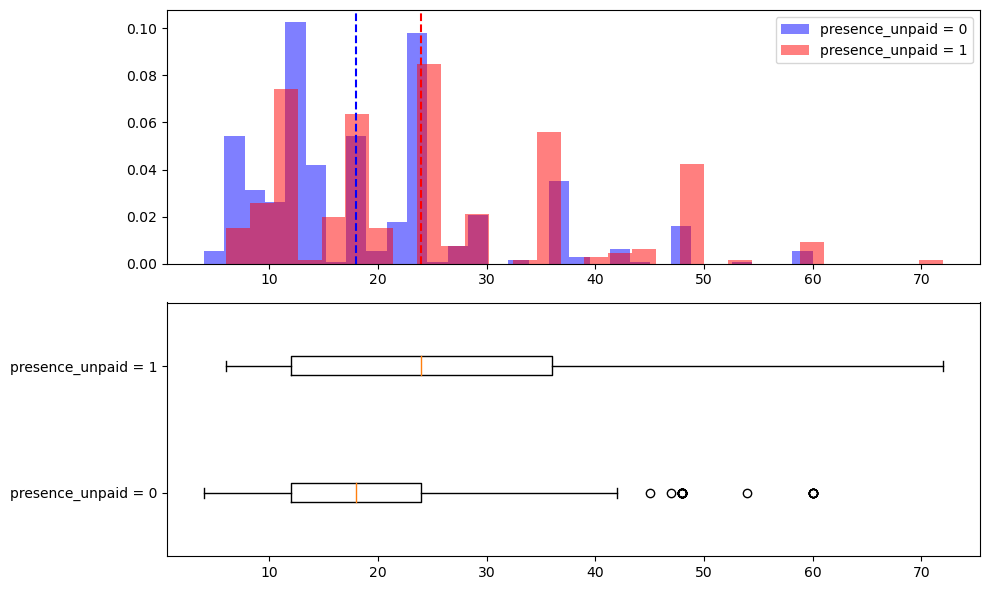


---------------------------------------------------------------------------

Discretization of duration_credit into 4 classes (algorithm Nelder-Mead)

---------------------------------------------------------------------------

Result of cutting :


Tresholds      % Negative  % Positive   # +   #   % #
                         0          1    1    0     1
duration_credit                                      
(-inf, 12.0]     78.830084  21.169916   76  359  35.9
(12.0, 18.0]     70.053476  29.946524   56  187  18.7
(18.0, 24.0]     70.535714  29.464286   66  224  22.4
(24.0, inf]      55.652174  44.347826  102  230  23.0

Convergence indicator (0 = convergence optimisation)
True

Maximum (partial) AUC  :
0.6089619047619048

Class homogeneity (0 <- low ... high -> 1) :
0.5820166523336594

AUC before cutting :
0.6285928571428572

AUC after cutting :
0.6089619047619048

% Evolution AUC before/after cutting :
-3.122999594710783




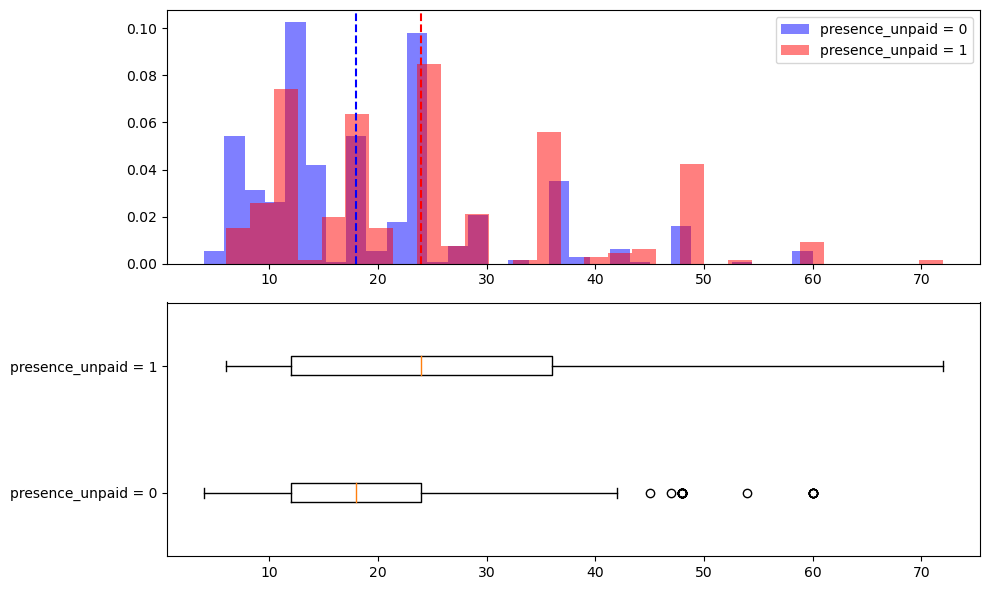


---------------------------------------------------------------------------

Discretization of duration_credit into 5 classes (algorithm Nelder-Mead)

---------------------------------------------------------------------------

Result of cutting :


Tresholds      % Negative  % Positive   # +   #   % #
                         0          1    1    0     1
duration_credit                                      
(-inf, 12.0]     78.830084  21.169916   76  359  35.9
(12.0, 15.0]     81.944444  18.055556   13   72   7.2
(15.0, 24.0]     67.846608  32.153392  109  339  33.9
(24.0, 30.0]     66.666667  33.333333   19   57   5.7
(30.0, inf]      52.023121  47.976879   83  173  17.3

Convergence indicator (0 = convergence optimisation)
True

Maximum (partial) AUC  :
0.6239452380952382

Class homogeneity (0 <- low ... high -> 1) :
0.477909892085279

AUC before cutting :
0.6285928571428572

AUC after cutting :
0.6239452380952382

% Evolution AUC before/after cutting :
-0.7393687336416503




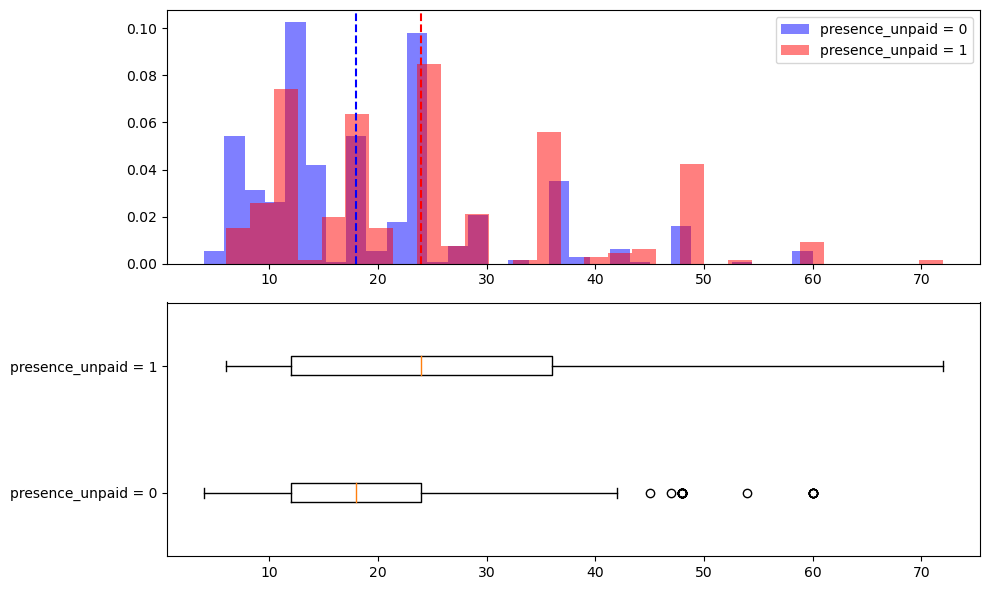

In [4]:
for i in range(2, 6):  
    qX_result = decoup(credit, 'duration_credit', 'presence_unpaid', nbmod=i, h=0, k=0, pAUC=0.8, graphe=1)


---------------------------------------------------------------------------

Discretization of amount_credit into 2 classes (algorithm Nelder-Mead)

---------------------------------------------------------------------------

Result of cutting :


Tresholds      % Negative  % Positive   # +   #   % #
                          0          1    1    0     1
amount_credit                                         
(-inf, 2435.475]  72.778828  27.221172  144  529  52.9
(2435.475, inf]   66.878981  33.121019  156  471  47.1

Convergence indicator (0 = convergence optimisation)
True

Maximum (partial) AUC  :
0.535

Class homogeneity (0 <- low ... high -> 1) :
0.8162005886940363

AUC before cutting :
0.5548571428571429

AUC after cutting :
0.535

% Evolution AUC before/after cutting :
-3.5787847579814707




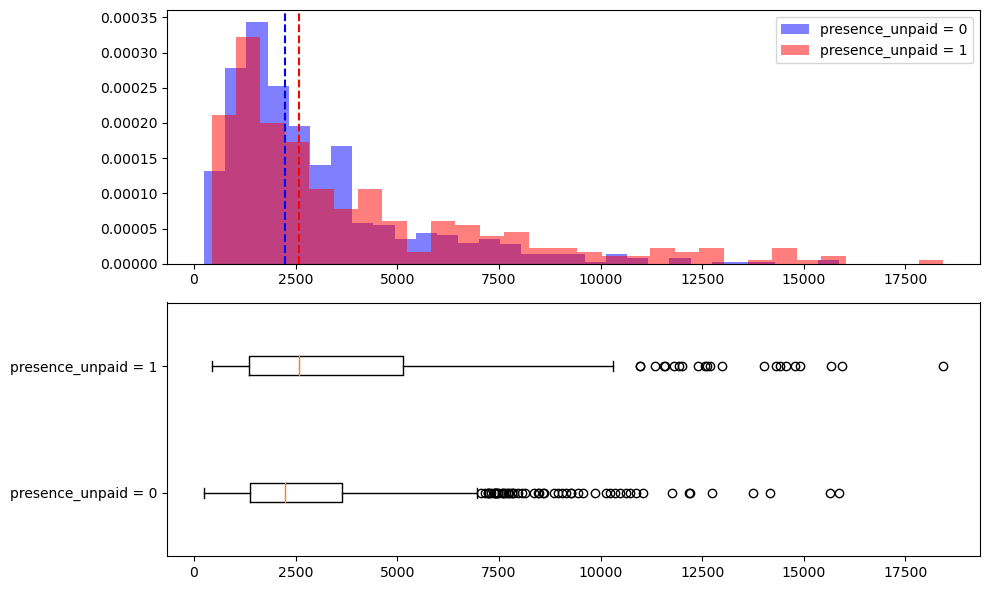


---------------------------------------------------------------------------

Discretization of amount_credit into 3 classes (algorithm Nelder-Mead)

---------------------------------------------------------------------------

Result of cutting :


Tresholds      % Negative  % Positive   # +   #   % #
                              0          1    1    0     1
amount_credit                                             
(-inf, 1373.029]      68.379447  31.620553   80  253  25.3
(1373.029, 3837.555]  77.405858  22.594142  108  478  47.8
(3837.555, inf]       58.364312  41.635688  112  269  26.9

Convergence indicator (0 = convergence optimisation)
True

Maximum (partial) AUC  :
0.6005142857142858

Class homogeneity (0 <- low ... high -> 1) :
0.6756114847843647

AUC before cutting :
0.5548571428571429

AUC after cutting :
0.6005142857142858

% Evolution AUC before/after cutting :
8.228630278063848




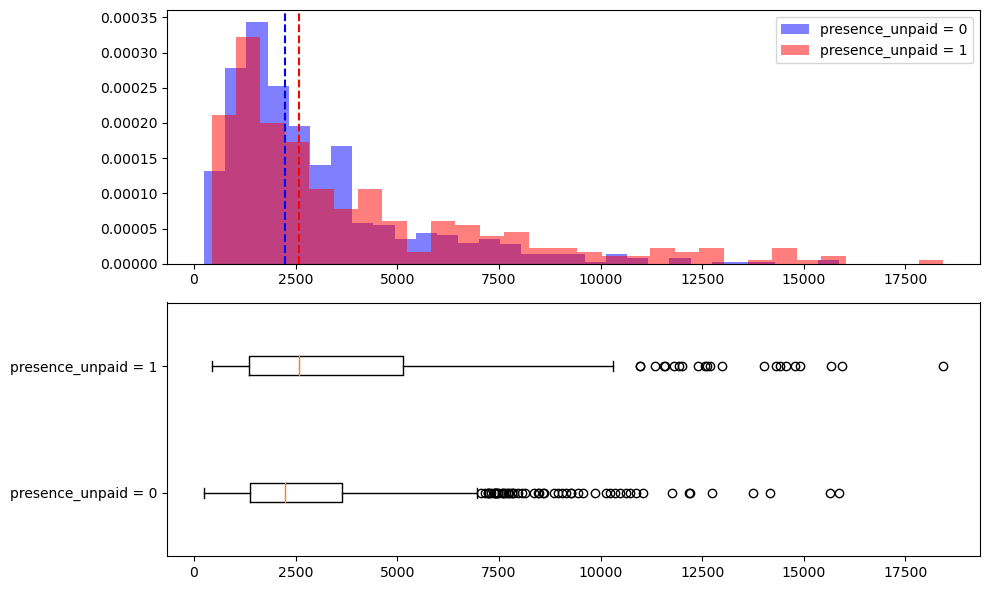


---------------------------------------------------------------------------

Discretization of amount_credit into 4 classes (algorithm Nelder-Mead)

---------------------------------------------------------------------------

Result of cutting :


Tresholds      % Negative  % Positive   # +   #   % #
                              0          1    1    0     1
amount_credit                                             
(-inf, 1349.907]      69.135802  30.864198   75  243  24.3
(1349.907, 2340.471]  75.655431  24.344569   65  267  26.7
(2340.471, 3913.37]   78.695652  21.304348   49  230  23.0
(3913.37, inf]        57.307692  42.692308  111  260  26.0

Convergence indicator (0 = convergence optimisation)
True

Maximum (partial) AUC  :
0.6058095238095238

Class homogeneity (0 <- low ... high -> 1) :
0.6178234884549029

AUC before cutting :
0.5548571428571429

AUC after cutting :
0.6058095238095238

% Evolution AUC before/after cutting :
9.182972880192224




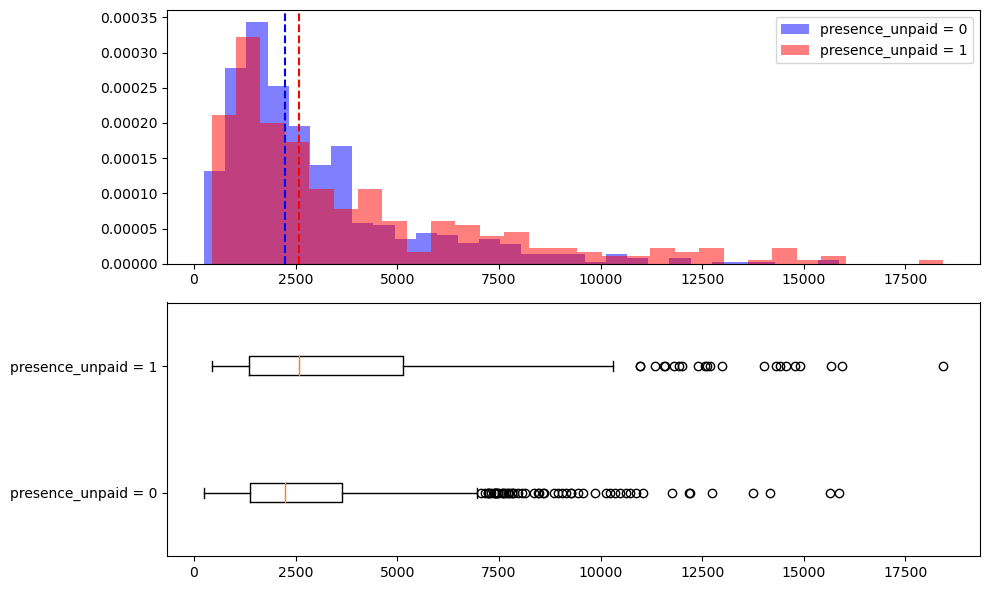


---------------------------------------------------------------------------

Discretization of amount_credit into 5 classes (algorithm Nelder-Mead)

---------------------------------------------------------------------------

Result of cutting :


Tresholds      % Negative  % Positive   # +   #   % #
                              0          1    1    0     1
amount_credit                                             
(-inf, 1410.654]      69.963370  30.036630   82  273  27.3
(1410.654, 1660.443]  80.722892  19.277108   16   83   8.3
(1660.443, 3234.789]  73.913043  26.086957   78  299  29.9
(3234.789, 3913.317]  84.705882  15.294118   13   85   8.5
(3913.317, inf]       57.307692  42.692308  111  260  26.0

Convergence indicator (0 = convergence optimisation)
True

Maximum (partial) AUC  :
0.6114214285714286

Class homogeneity (0 <- low ... high -> 1) :
0.5989121475212782

AUC before cutting :
0.5548571428571429

AUC after cutting :
0.6114214285714286

% Evolution AUC before/after cutt

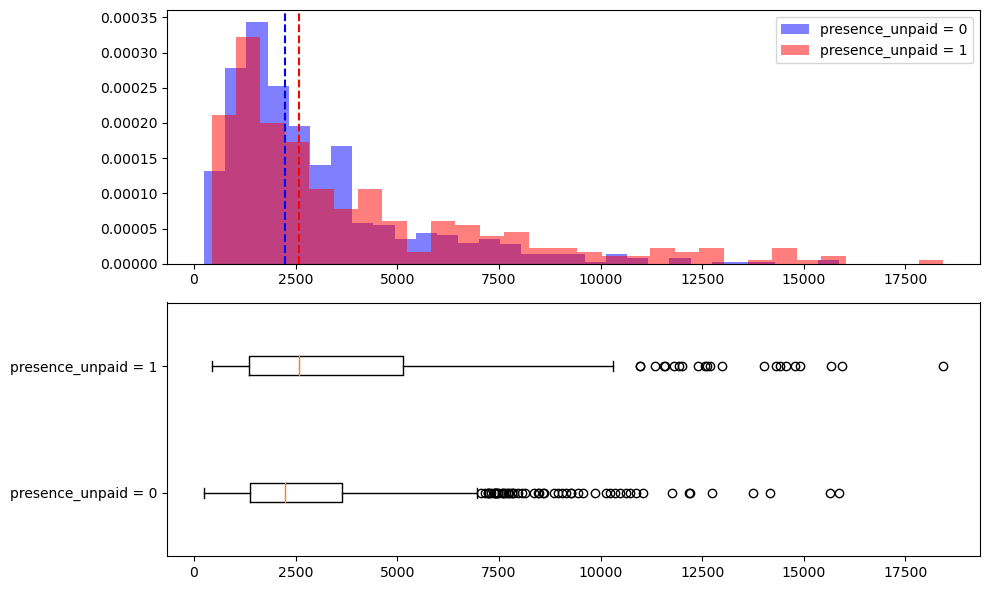

In [5]:
for i in range(2, 6):  
    qX_result = decoup(credit, 'amount_credit', 'presence_unpaid', nbmod=i, h=0, k=0, pAUC=0.8, graphe=1)